# Introduction

This notebook explores the use of Label Smoothing and its effects on reducing overfitting. Idea was obtained from "Bag of Tricks for Image Classification with Convolutional Neural Networks" by Tong et al. (2018). First proposed by Szegedy et al. (2015) in "Rethinking the Inception Architecture for Computer Vision"

In [ ]:
import time
import math
import jax
import numpy as np
import jax.numpy as jnp
#dataframes and arrays 
import pandas as pd 

#plotting 
import matplotlib.pyplot as plt

#building & fitting the model 
import tensorflow as tf 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential 

#fine tuning
from tensorflow.keras.callbacks import LearningRateScheduler

In [ ]:
print(tf.__version__)

2.11.0


# A Demonstration of Label Smoothing


In [ ]:
#Demo of smoothing
y_hot = jnp.array([1.,0.,0.,0.,0.,0.,0.,0.,0.,0.])
smoothing = 0.2
n_class = 10
y_hot = y_hot*(1-smoothing) + smoothing/n_class
y_hot

Array([0.82, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02],      dtype=float32)

# Main Experiment

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#set the working directory to where the data is stored
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
class_names=["fish", "dog", "device", "chainsaw", "church", "horn", "truck", "petrol", "golf", "parachute"]

# load data -- be patient, does take a few seconds
data_train_all = np.load("assignment_1_train.npz")
data_test = np.load("assignment_1_test.npz")

In [ ]:
train_size = data_train_all["img"].shape[0]
#Read Labels
Y_train = data_train_all["label"].astype(int)
Y_test = data_test["label"].astype(int)

In [ ]:
# One hot encode the labels
Y_train = jax.nn.one_hot(Y_train,10)
Y_test = jax.nn.one_hot(Y_test,10)

In [ ]:
# Create dataset object
train_ds = tf.data.Dataset.from_tensor_slices((data_train_all["img"], Y_train))
test_ds = tf.data.Dataset.from_tensor_slices((data_test["img"], Y_test))

In [ ]:
#Shuffle and split into train/valid set
train_ds = train_ds.shuffle(train_size, reshuffle_each_iteration = False, seed = 4212)
val_ds = train_ds.take(train_size//5)
train_ds = train_ds.skip(train_size//5)

#Set batch size = 32
train_ds = train_ds.batch(32)
val_ds = val_ds.batch(32)
test_ds = test_ds.batch(32)

#prefetching + caching
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(9999).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Plot for Experiments
plt.style.use('ggplot')
def plot_accuracy_loss(fit_history1, fit_history2): 
  
  #Train Accuracy (Graph 1)
  train_acc1 = fit_history1.history['accuracy']
  train_acc2 = fit_history2.history['accuracy']
  
  #Train Loss (Graph 2)
  train_loss1 = fit_history1.history['loss']
  train_loss2 = fit_history2.history['loss']
  
  #Valid Accuracy (Graph 3)
  val_acc1 = fit_history1.history['val_accuracy']
  val_acc2 = fit_history2.history['val_accuracy']

  #Valid Loss (Graph 4)
  val_loss1 = fit_history1.history['val_loss']
  val_loss2 = fit_history2.history['val_loss']

  num_epochs = len(fit_history1.history['val_accuracy'])
  x_range = range(num_epochs)

  fig, axs = plt.subplots(2, 2, figsize=(15, 15))
  #Top left 
  axs[0, 0].plot(x_range, train_acc1, label="without label smoothing")
  axs[0, 0].plot(x_range, train_acc2, label="with label smoothing")
  axs[0, 0].set_title('Training Accuracy')
  axs[0,0].legend()
  #top right
  axs[0, 1].plot(x_range, train_loss1, label="without label smoothing")
  axs[0, 1].plot(x_range, train_loss2, label="with label smoothing")
  axs[0, 1].set_title('Training Loss')
  axs[0,1].legend()
  #bottom left
  axs[1, 0].plot(x_range, val_acc1, label="without label smoothing")
  axs[1, 0].plot(x_range, val_acc2, label="with label smoothing")
  axs[1, 0].set_title('Validation Accuracy')
  axs[1,0].legend()
  #bottom right
  axs[1, 1].plot(x_range, val_loss1, label="without label smoothing")
  axs[1, 1].plot(x_range, val_loss2, label="with label smoothing")
  axs[1, 1].set_title('Validation Loss')
  axs[1,1].legend()
  
  plt.show()

In [ ]:
#Defining the decay rate scheduler
def exp_decay(epoch, lr):
  if epoch < 5:
    return lr
  elif epoch <=10:
    return lr*tf.math.exp(-0.1)
  elif epoch <=16:
    return lr*tf.math.exp(-0.15)
  else: 
    return lr*tf.math.exp(-0.2)
lrate = LearningRateScheduler(exp_decay)

In [ ]:
#Base Case (No Label Smoothing)
num_classes = len(class_names)
#Build the model
model = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer = 'he_uniform'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer = 'he_uniform'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer = 'he_uniform'),
  layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation='tanh'),
  layers.Dense(num_classes, activation ='softmax')
])
#compile with loss function and optimizer
model.compile(
    loss=tf.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0028),
    metrics=['accuracy']
  )    

In [ ]:
epochs = 23
#fit model and track time taken
start = time.time()
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    callbacks = [lrate]
)
end = time.time()
time_taken1 = end-start

Epoch 1/23
233/233 [==============================] - 6s 18ms/step - loss: 1.8721 - accuracy: 0.3282 - val_loss: 1.6012 - val_accuracy: 0.4449 - lr: 0.0028
Epoch 2/23
233/233 [==============================] - 4s 17ms/step - loss: 1.4806 - accuracy: 0.4907 - val_loss: 1.3699 - val_accuracy: 0.5336 - lr: 0.0028
Epoch 3/23
233/233 [==============================] - 4s 18ms/step - loss: 1.2800 - accuracy: 0.5738 - val_loss: 1.2565 - val_accuracy: 0.5858 - lr: 0.0028
Epoch 4/23
233/233 [==============================] - 4s 18ms/step - loss: 1.1806 - accuracy: 0.6009 - val_loss: 1.1832 - val_accuracy: 0.6315 - lr: 0.0028
Epoch 5/23
233/233 [==============================] - 4s 17ms/step - loss: 1.0945 - accuracy: 0.6340 - val_loss: 1.1211 - val_accuracy: 0.6299 - lr: 0.0028
Epoch 6/23
233/233 [==============================] - 4s 17ms/step - loss: 1.0048 - accuracy: 0.6661 - val_loss: 1.0387 - val_accuracy: 0.6606 - lr: 0.0025
Epoch 7/23
233/233 [==============================] - 4s 18ms/st

In [ ]:
#With Label Smoothing
num_classes = len(class_names)
#Repeat same steps in base case
model2 = Sequential([
  layers.Rescaling(1./255, input_shape=(128, 128, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu', kernel_initializer = 'he_uniform'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu', kernel_initializer = 'he_uniform'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu', kernel_initializer = 'he_uniform'),
  layers.GlobalAveragePooling2D(),
  layers.Dense(128, activation='tanh'),
  layers.Dense(num_classes, activation ='softmax')
])
#Adding label smoothing to loss function this time
model2.compile(
    loss=tf.losses.CategoricalCrossentropy(label_smoothing = 0.2),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0028),
    metrics=['accuracy']
  )    

In [ ]:
epochs = 23

start = time.time()
history2 = model2.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs,
    callbacks = [lrate]
)
end = time.time()
time_taken2 = end - start

Epoch 1/23
233/233 [==============================] - 6s 18ms/step - loss: 2.0807 - accuracy: 0.3079 - val_loss: 1.8654 - val_accuracy: 0.4449 - lr: 0.0028
Epoch 2/23
233/233 [==============================] - 4s 18ms/step - loss: 1.8005 - accuracy: 0.5026 - val_loss: 1.7835 - val_accuracy: 0.5137 - lr: 0.0028
Epoch 3/23
233/233 [==============================] - 6s 24ms/step - loss: 1.6724 - accuracy: 0.5871 - val_loss: 1.6584 - val_accuracy: 0.5836 - lr: 0.0028
Epoch 4/23
233/233 [==============================] - 4s 17ms/step - loss: 1.5962 - accuracy: 0.6263 - val_loss: 1.5976 - val_accuracy: 0.6342 - lr: 0.0028
Epoch 5/23
233/233 [==============================] - 4s 18ms/step - loss: 1.5270 - accuracy: 0.6708 - val_loss: 1.4974 - val_accuracy: 0.6859 - lr: 0.0028
Epoch 6/23
233/233 [==============================] - 4s 17ms/step - loss: 1.4730 - accuracy: 0.6988 - val_loss: 1.4865 - val_accuracy: 0.6783 - lr: 0.0025
Epoch 7/23
233/233 [==============================] - 4s 17ms/st

# Comparing the results

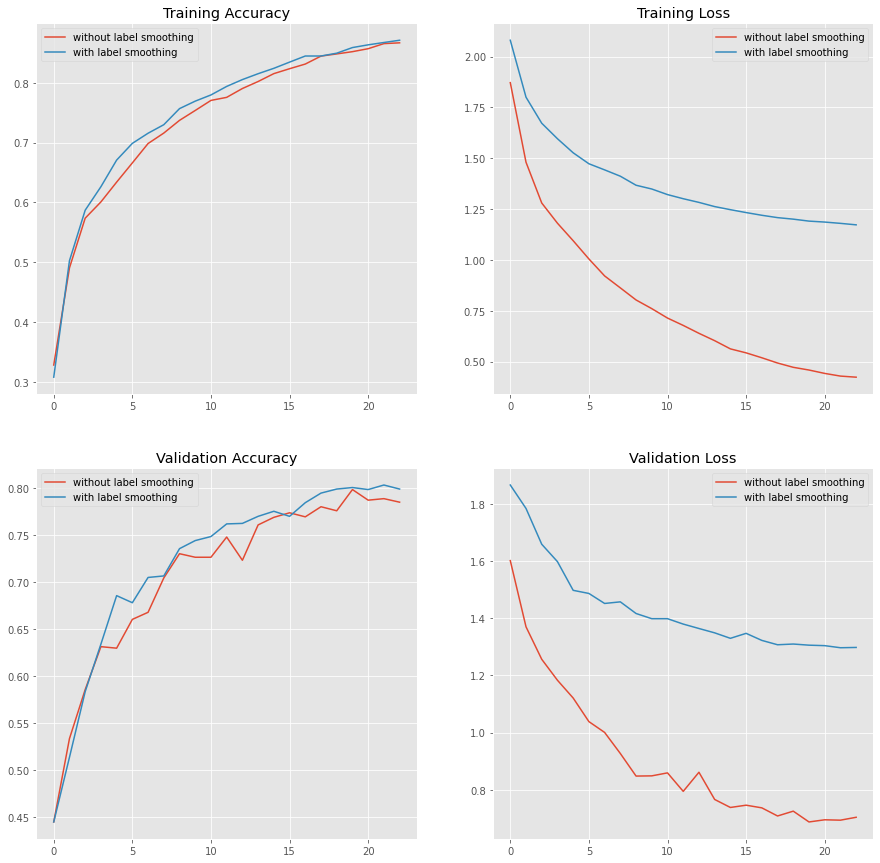

121/121 [==============================] - 1s 7ms/step - loss: 0.7207 - accuracy: 0.7790
Test accuracy (Without Label Smoothing):  0.7790456414222717
121/121 [==============================] - 1s 6ms/step - loss: 1.2916 - accuracy: 0.7977
Test accuracy (With Label Smoothing):  0.7977178692817688
Time taken (Without Label Smoothing):  101.71821117401123
Time taken (With Label Smoothing):  105.60308122634888


In [ ]:
#Visualising the difference between the experiments
plot_accuracy_loss(history, history2)
print("Test accuracy (Without Label Smoothing): ", model.evaluate(test_ds)[1])
print("Test accuracy (With Label Smoothing): ", model2.evaluate(test_ds)[1])
print("Time taken (Without Label Smoothing): ", time_taken1)
print("Time taken (With Label Smoothing): ", time_taken2)

## Conclusion

With Label Smoothing we were able to achieve a higher validation accuracy. Differences in training time were minimal. The difference in training and validation loss is due to the effects of label smoothing on loss computation and should be ignored.